## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datos_unidos = pd.read_csv("../data/procesados/datos_unidos.csv")

## Ganancias

Veamos la reducción de ganancia por día 

In [7]:
import matplotlib.dates as mdates

In [ ]:
# Calcular ganancia por fila
datos_unidos['GAIN'] = (datos_unidos['PRICE'] - datos_unidos['COSTOS']) * datos_unidos['QUANTITY']

gain_total = datos_unidos.groupby('DATE')['GAIN'].sum().reset_index()
gain_total["DATE"] = pd.to_datetime(gain_total["DATE"])

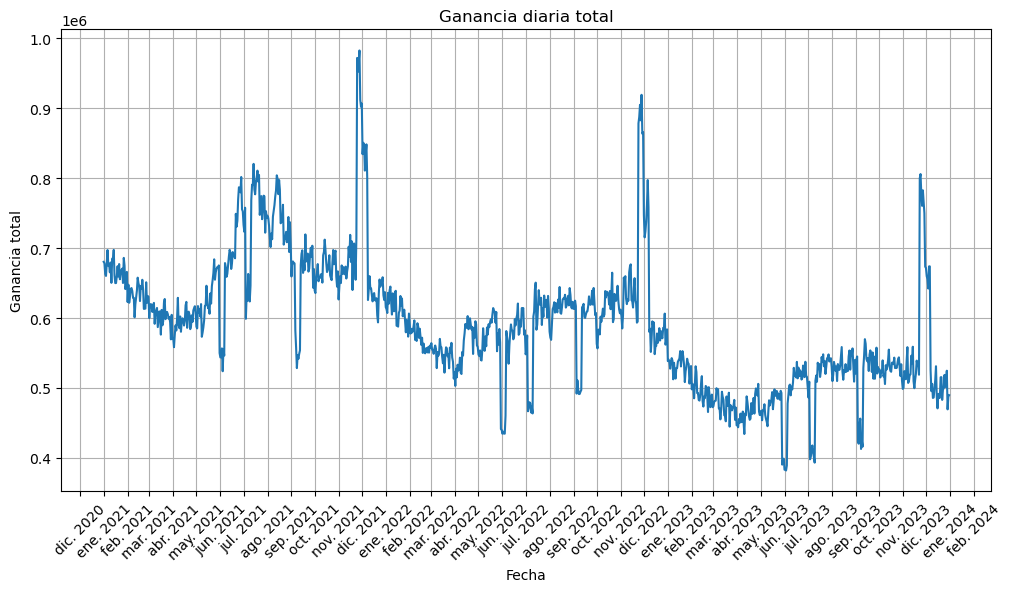

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(gain_total['DATE'], gain_total['GAIN'])
plt.title('Ganancia diaria total')
plt.xlabel('Fecha')
plt.ylabel('Ganancia total')
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())       # pone un tick por mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # formatea como 'Ene 2025'

plt.xticks(rotation=45)
plt.show()

En el panorama global, vemos una caída gradual de las ganancias conforme pasan los años.

A nivel año, las ganancias en general suben a medida que pasa el año y descienden a principios de cada año.

Además, vemos que en Mayo, Junio y Agosto hay caídas abruptas de las ganancias, como también hay subidas abruptas en diciembre.
Además

In [ ]:
# Veamos las pérdidas de cada año
gain_total["YEAR"] = gain_total["DATE"].dt.year
gain_total.groupby(by="YEAR")["GAIN"].sum()

YEAR
2021    2.443788e+08
2022    2.167506e+08
2023    1.864205e+08
Name: GAIN, dtype: float64

In [28]:
perdida_2y = round((216750585.87-244378830.55)/216750585.87 * 100, 2)
perdida_3y = round((186420480.41 - 216750585.87)/ 216750585.87 * 100, 2)

In [29]:
print(f"Perdida en el segundo año: {perdida_2y}%")
print(f"Perdida en el tercer año: {perdida_3y}%")

Perdida en el segundo año: -12.75%
Perdida en el tercer año: -13.99%


## Demanda

In [14]:
datos_unidos["DATE"] = pd.to_datetime(datos_unidos["DATE"])

In [11]:
datos_unidos["CATEGORY"].unique()

array(['Beauty', 'Books', 'Clothing', 'Electronics', 'Groceries',
       'Home & Kitchen', 'Sports', 'Toys'], dtype=object)

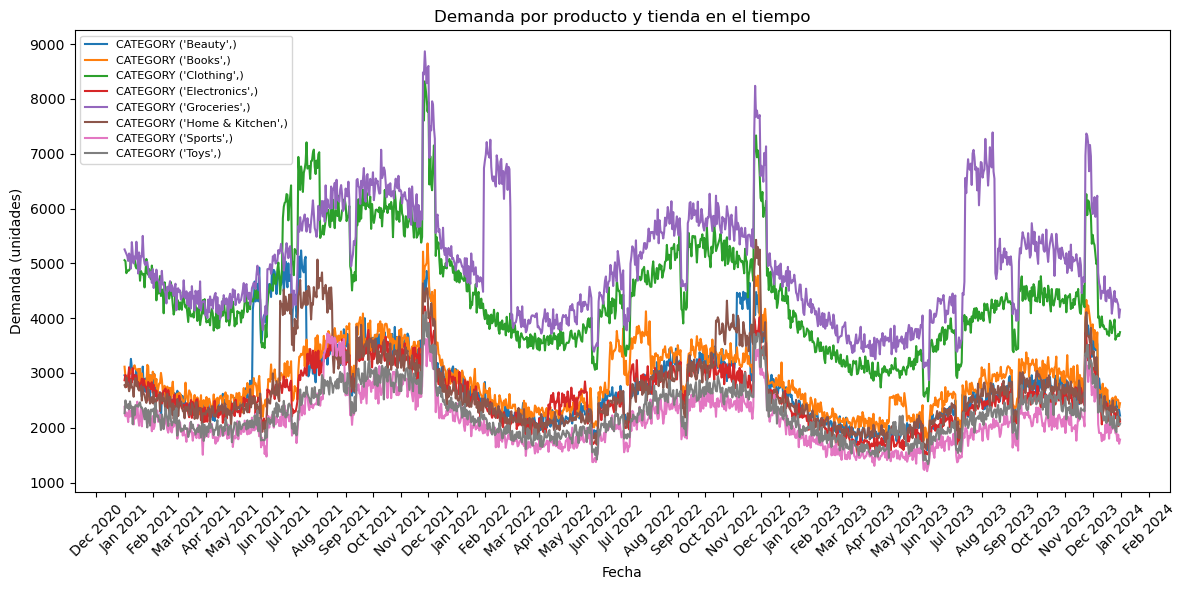

In [24]:
demanda = datos_unidos.groupby(['DATE', 'CATEGORY'])['QUANTITY'].sum().reset_index()

subgrupos = demanda.groupby(['CATEGORY'])

plt.figure(figsize=(12, 6))
for subgroup, data in subgrupos:
    plt.plot(data['DATE'], data['QUANTITY'], label=f"CATEGORY {subgroup}")

plt.xlabel("Fecha")
plt.ylabel("Demanda (unidades)")
plt.title("Demanda por producto y tienda en el tiempo")
plt.legend(loc="upper left", fontsize=8)
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()

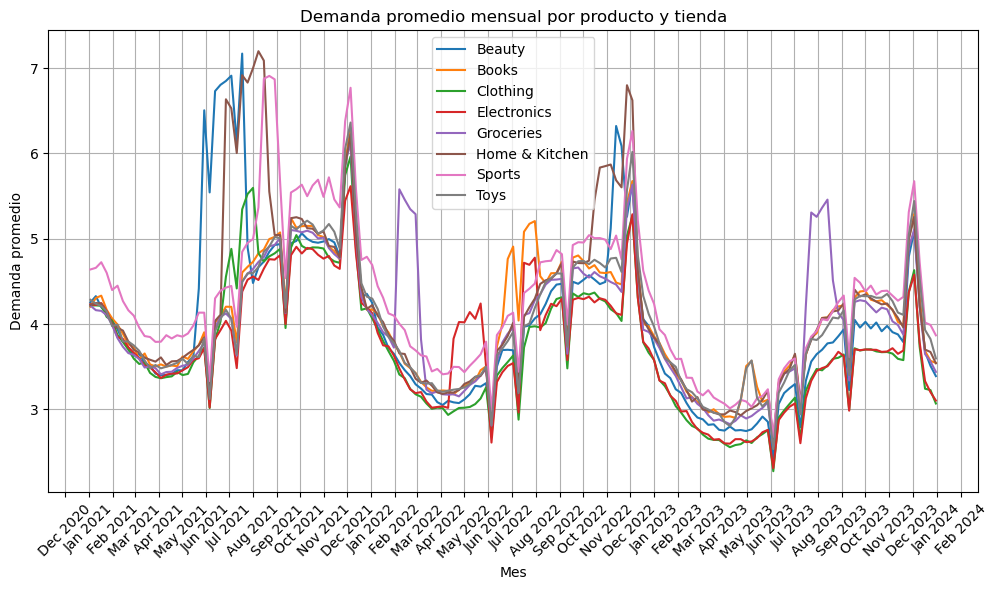

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar por mes, SKU y STORE_ID
df_monthly = (
    datos_unidos.groupby([pd.Grouper(key="DATE", freq="W"), "CATEGORY"])["QUANTITY"]
    .mean()
    .reset_index()
)

# Graficar
plt.figure(figsize=(12, 6))

# 8 colores bien diferenciados (Set2)
category_colors = {
    cat: color
    for cat, color in zip(df_monthly["CATEGORY"].unique(), plt.cm.Set2.colors[:8])
}

for category, sub_df in df_monthly.groupby("CATEGORY"):
    plt.plot(sub_df["DATE"], sub_df["QUANTITY"], label=category)

plt.xlabel("Mes")
plt.ylabel("Demanda promedio")
plt.title("Demanda promedio mensual por producto y tienda")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Precios